In [1]:
import torch
import torch.nn as nn
from utils import create_bbox_mask
from torch.utils.data import DataLoader
from torchvision import transforms
transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
from data_loader.data_loaders import CocoDataset, collate_fn
from model.model import *

BATCH_SIZE = 256
seed = 42
torch.manual_seed(seed)
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device)
model = FeatureSynthesisModel(embed_dim=1024)
model = model.to(device)
# model.load_state_dict(torch.load('saved/models/word2vec/0831_154110/checkpoint-epoch50.pth')['state_dict'])
model.load_state_dict(torch.load('saved/models/clip_template_RN50/1016_225637/checkpoint-epoch50.pth')['state_dict'])
model.eval()  # set to evaluation mode







: 

In [2]:
from utils import convert_query_to_tensor, create_bbox_mask, one_hot_embedding, coco_clip_embedding_fn, clip_embedding_fn
import fasttext, fasttext.util
import numpy as np

In [15]:
train_set = CocoDataset(root='./data/coco', mode='gallery')
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, collate_fn=collate_fn)
all_features = torch.load('./data/coco/gallery/features/resnet50_features.pt')
all_img_features = torch.stack(list(all_features.values()))
all_img_ids = np.array(list(all_features.keys()))
all_categories = []
all_bboxes = []
# embed_fn = fasttext.load_model('cc.en.300.bin').get_word_vector
embed_fn = clip_embedding_fn()

queries = None
query_ids = None
index = 1
with torch.no_grad():
    for i, (img_ids, layouts, _) in enumerate(train_loader):
        query_features = []
        each_query_features = []
        batch_size = len(img_ids)
        for j in range(batch_size):
            # for k in range(len(layouts[j])): layouts[j][k]['category'] = 'bread'
            canvas_tensor = convert_query_to_tensor(layouts[j], 1024, mode='clip', embedding_fn=embed_fn)
            canvas_tensor = canvas_tensor.to(device)
            output_feature = model(canvas_tensor)
            masks = torch.stack([create_bbox_mask(layouts[j][k]['bbox'], 7) for k in range(len(layouts[j]))]).unsqueeze(1).to(device)
            # normalize the output feature
            output_feature = output_feature / (torch.norm(output_feature, dim=1, keepdim=True) + 1e-10)
            output_feature = output_feature * masks
            each_query_features.append(output_feature.cpu().numpy())
            output_feature, _ = torch.max(output_feature, dim=0)
            query_features.append(output_feature.view(1, -1).cpu().numpy())
        
        if i == index: 
            query_features = np.concatenate(query_features, axis=0)
            queries = layouts
            query_ids = img_ids
            break
        # imgs = imgs.to(device)
        # img_features = backbone_model(imgs)
        # all_img_features.append(img_features.cpu().detach())
        # all_img_ids.extend(queries[3])
        # all_categories.extend(queries[0])
        # all_bboxes.extend(queries[1])
print(query_features)
print(all_img_features.shape)

/home/mmlab/gschoi/bbir/utils/canvas.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cat_embedding = torch.tensor(embedding_fn(obj['category']))[0]


[[0.00534835 0.00229511 0.00026844 ... 0.         0.         0.        ]
 [0.02612711 0.02982168 0.02837432 ... 0.04245969 0.04771565 0.04499432]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.02024109 0.02058722 0.0194064 ]
 [0.         0.         0.         ... 0.0129472  0.01175939 0.012863  ]]
torch.Size([68287, 2048, 7, 7])


In [5]:
from pycocotools.coco import COCO
coco = COCO('./data/coco/annotations/instances_train2017.json')

loading annotations into memory...
Done (t=13.65s)
creating index...
index created!


In [7]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=10, algorithm='auto', metric='cosine').fit(all_img_features.view(len(all_img_features), -1).numpy())
distances, indices = nbrs.kneighbors(query_features)

In [6]:
from utils import BatchKNearestNeighbor

nbrs = BatchKNearestNeighbor(batch_size=5000, device=device, mask=True)
nbrs.fit(all_img_features.view(all_img_features.shape[0], -1).numpy())

In [7]:
indices, distances = nbrs.predict(query_features, k=20)
print(query_features)

[[0.         0.         0.         ... 0.         0.00695625 0.01302064]
 [0.         0.         0.         ... 0.01674215 0.         0.        ]
 [0.         0.         0.01130068 ... 0.02066546 0.01879703 0.        ]
 ...
 [0.         0.         0.         ... 0.02010692 0.02102246 0.01820083]
 [0.         0.         0.         ... 0.01903773 0.02229123 0.02052647]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [15]:
query_idx = 166
masks = torch.stack([create_bbox_mask(layouts[query_idx][k]['bbox'], 7) for k in range(len(layouts[query_idx]))]).unsqueeze(1).to(device)
masks = torch.max(masks, dim=0)[0]
masked_img_features = all_img_features.to(device) * masks
print(masks)
# nbrs = NearestNeighbors(n_neighbors=10, algorithm='auto', metric='cosine').fit(masked_img_features.view(len(masked_img_features), -1).cpu().numpy())
# distances, indices = nbrs.kneighbors(query_features[query_idx].reshape(1, -1))

tensor([[[1., 1., 1., 1., 0., 0., 0.],
         [1., 1., 1., 1., 0., 0., 0.],
         [1., 1., 1., 1., 0., 0., 0.],
         [1., 1., 1., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.]]], device='cuda:1')


In [12]:
def is_relevant(query_layouts, ranked_img_id, coco):
    img = coco.loadImgs([ranked_img_id])[0]
    ann = coco.loadAnns(coco.getAnnIds(imgIds=[ranked_img_id]))
    ranked_img_layouts = [ann[i] for i in range(len(ann))]
    H, W = img['height'], img['width']
    num_bounding_boxes = len(query_layouts)
    rel_score = 0
    for query_layout in query_layouts:
        # calculate miou
        x1, y1, w1, h1 = query_layout['bbox']
        x1, y1, w1, h1 = x1 * W, y1 * H, w1 * W, h1 * H
        min_x1, min_y1, max_x1, max_y1 = int(x1 - w1 / 2), int(y1 - h1 / 2), math.ceil(x1 + w1 / 2), math.ceil(y1 + h1 / 2)
        query_cat = query_layout['category']
        max_iou = 0
        for ranked_img_layout in ranked_img_layouts:
            if coco.getCatIds(catNms=[query_cat])[0] != ranked_img_layout['category_id']:
                continue
            x2, y2, w2, h2 = ranked_img_layout['bbox']
            min_x2, min_y2, max_x2, max_y2 = int(x2), int(y2), math.ceil(x2 + w2), math.ceil(y2 + h2)
            
            # compute miou
            min_x = max(min_x1, min_x2)
            min_y = max(min_y1, min_y2)
            max_x = min(max_x1, max_x2)
            max_y = min(max_y1, max_y2)
            intersection = max(0, max_x - min_x) * max(0, max_y - min_y)
            union = w1 * h1 + w2 * h2 - intersection
            miou = intersection / union
            max_iou = max(max_iou, miou)
        rel_score += max_iou
    rel_score /= num_bounding_boxes
    print(rel_score)
    return rel_score > 0.3

In [57]:
coco.loadImgs(284743)[0]

{'license': 1,
 'file_name': '000000284743.jpg',
 'coco_url': 'http://images.cocodataset.org/val2017/000000284743.jpg',
 'height': 425,
 'width': 640,
 'date_captured': '2013-11-22 21:17:52',
 'flickr_url': 'http://farm4.staticflickr.com/3348/3449687086_e7e2156c9b_z.jpg',
 'id': 284743}

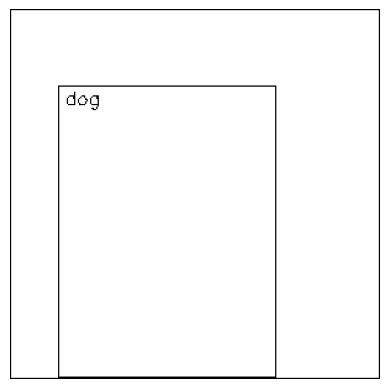

3771


In [16]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math

query_idx = 63
# draw a 31 x 31 empty grid
l = 300
grid = np.zeros((l, l, 3))
# draw the bounding box
for i in range(len(queries[query_idx])):
    x, y, w, h = queries[query_idx][i]['bbox']
    x, y, w, h = l * x, l * y, l * w, l * h
    x_min, y_min = int(x - w / 2), int(y - h / 2)
    x_max, y_max = math.ceil(x + w / 2), math.ceil(y + h / 2)
    cv2.rectangle(grid, (x_min, y_min), (x_max, y_max), (1, 1, 1), 1)
    text = f'{queries[query_idx][i]["category"]}'
    cv2.putText(grid, text, (x_min+5, y_min+15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (1, 1, 1), 1)

# draw edge around the grid.
grid[0, :, :] = 1
grid[-1, :, :] = 1
grid[:, 0, :] = 1
grid[:, -1, :] = 1

grid = 1 - grid
plt.imshow(grid)
plt.axis('off')
plt.show()

print(len(train_set))

517523


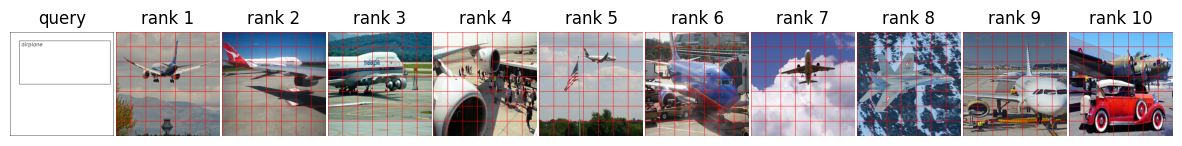

In [26]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# ranked_list = all_img_ids[indices[query_idx]]
ranked_list = all_img_ids[indices[query_idx]]
# relevant_positions = [idx for idx, img in enumerate(ranked_list) if is_relevant(queries[query_idx], img, coco=coco)]
img_paths = [f'./data/coco/val2017/images/000000{all_img_ids[indices[query_idx][i]]:06}.jpg' for i in range(20)]
# img_paths = [f'./data/coco/gallery/images/000000{all_img_ids[indices[query_idx][i]]:06}.jpg' for i in range(10)]

# img_path = f'./data/coco/val2017/images/000000221281.jpg'
print(query_ids[query_idx])

TARGET_SIZE = (256, 256)  # Adjust as needed

plt.figure(figsize=(15, 10))

# Display the 'query' image in the first position
plt.subplot(2, 11, 1) # for 1 row and 11 columns (1 query + 10 results)
plt.imshow(grid)
plt.axis('off')
plt.title('query')

# Loop through and display 10 result images
for i in range(10):
    plt.subplot(2, 11, i+2) # for 1 row and 11 columns
    img = Image.open(img_paths[i])
    
    # Resize the image to target size
    img = img.resize(TARGET_SIZE, Image.LANCZOS)

    draw = ImageDraw.Draw(img)
    width, height = img.size
    x_spacing = width / 7
    y_spacing = height / 7
    
    # Draw grid lines
    for j in range(8):
        x = int(x_spacing * j)
        draw.line([(x, 0), (x, height)], fill='red')
    for j in range(8):
        y = int(y_spacing * j)
        draw.line([(0, y), (width, y)], fill='red')
    
    # Draw a light green border for relevant positions
    # if i in relevant_positions:
    #     draw.rectangle([(0, 0), (width, height)], outline='lightgreen', width=7)

    # Display the image
    plt.imshow(img)
    plt.axis('off')
    # plt.title(f'rank {i+1}, img: {all_img_ids[indices[query_idx][i]]}, distance: {distances[query_idx][i]:.3f}')
    plt.title(f'rank {i+1}')

plt.subplots_adjust(wspace=0.02, hspace=0)
plt.show()



In [58]:
from torchvision.models import resnet50
import torch.nn as nn
tmp_model = resnet50(pretrained=True)
gap_layer = list(tmp_model.children())[-2]

# Extract the fully connected layer
fc_layer = list(tmp_model.children())[-1]

tmp_feature = query_features[query_idx].reshape(2048, 7, 7)
tmp_feature = torch.from_numpy(tmp_feature).unsqueeze(0)

# Pass the feature through the global average pooling layer
pooled_feature = gap_layer(tmp_feature)
print(pooled_feature.shape)
# Flatten the pooled feature
flattened_feature = pooled_feature.view(pooled_feature.size(0), -1)

# Pass the flattened feature through the fully connected layer
pred = fc_layer(flattened_feature)
print(torch.argmax(pred, dim=1))


/home/mmlab/anaconda3/envs/bbir/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mmlab/anaconda3/envs/bbir/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 2048, 1, 1])
tensor([879])


In [205]:
from torchvision.models import resnet50
from PIL import Image, ImageDraw
import torch, torchvision
import matplotlib.pyplot as plt

model = resnet50(pretrained=True)
img_path = f'./data/coco/val2017/images/000000{all_img_ids[indices[query_idx][3]]:06}.jpg'
img = Image.open(img_path)
img = torchvision.transforms.Resize((224, 224))(img)
img_tensor = torchvision.transforms.ToTensor()(img)
img_tensor = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img_tensor)
model.eval()
pred = model(img_tensor.unsqueeze(0))
print(torch.argmax(pred, dim=1))

tensor([542])


In [54]:
cat_vec = embed_fn('furniture')
vec_1 = embed_fn('dog')

# distance between cat and furniture
np.dot(cat_vec, vec_1) / (np.linalg.norm(cat_vec) * np.linalg.norm(vec_1))

0.52298087

In [89]:
import json
query_path = './data/coco/train/query_.json'
with open(query_path, 'r') as f:
    query = json.load(f)
label_path = './data/coco/labels.txt'
with open(label_path, 'r') as f:
    labels = f.read().split('\n')

count_labels = {}
for q in query:
    label = q['layout']['category']
    if label not in count_labels:
        count_labels[label] = 0
    count_labels[label] += 1
print(count_labels)

{'dining table': 4017, 'teddy bear': 832, 'cake': 664, 'bench': 905, 'person': 24207, 'dog': 1137, 'clock': 219, 'motorcycle': 1085, 'bowl': 1060, 'broccoli': 455, 'chair': 1587, 'apple': 253, 'bed': 1455, 'backpack': 184, 'hot dog': 329, 'elephant': 1047, 'horse': 965, 'fork': 201, 'carrot': 203, 'couch': 1550, 'boat': 629, 'microwave': 123, 'cell phone': 219, 'train': 1398, 'bus': 1172, 'book': 476, 'pizza': 1162, 'knife': 223, 'orange': 314, 'sandwich': 845, 'bird': 560, 'airplane': 1043, 'snowboard': 139, 'tv': 625, 'keyboard': 293, 'mouse': 41, 'umbrella': 781, 'suitcase': 583, 'cat': 1386, 'car': 1058, 'banana': 648, 'cup': 419, 'giraffe': 1296, 'truck': 1017, 'oven': 563, 'potted plant': 522, 'tie': 219, 'bicycle': 482, 'baseball bat': 85, 'spoon': 123, 'zebra': 949, 'bottle': 319, 'surfboard': 375, 'skateboard': 179, 'vase': 405, 'traffic light': 79, 'laptop': 818, 'refrigerator': 640, 'wine glass': 236, 'sink': 360, 'toilet': 757, 'bear': 340, 'parking meter': 108, 'cow': 665,

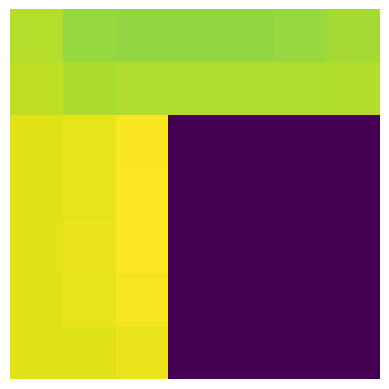

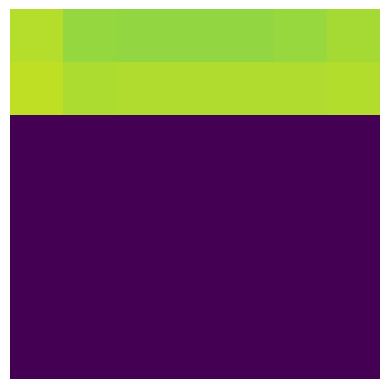

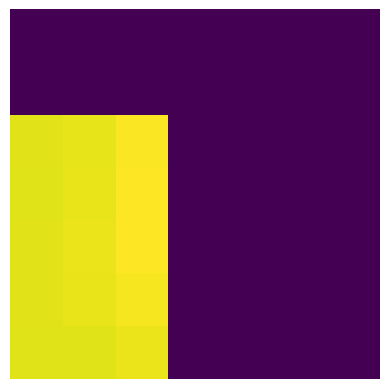

In [58]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math


query_feature_map = query_features[query_idx].reshape(2048, 7, 7)
gray_scale = np.average(query_feature_map, axis=0)
gray_scale = gray_scale / np.max(gray_scale)
plt.imshow(gray_scale)
plt.axis('off')
plt.show()

global_min = np.min([np.abs(np.average(item, axis=0)) for item in each_query_features[query_idx]])
global_max = np.max([np.abs(np.average(item, axis=0)) for item in each_query_features[query_idx]])
for item in each_query_features[query_idx]:
    each_query_feature_map = item
    each_gray_scale = np.average(each_query_feature_map, axis=0)
    each_gray_scale = each_gray_scale / np.max(gray_scale)
    plt.imshow(each_gray_scale, vmin=global_min, vmax=global_max)
    plt.axis('off')
    plt.show()



# why is the color of zero value purple?
# gray_scale = gray_scale / np.max(gray_scale)
# gray_scale = gray_scale * 255 
# plt.imshow(gray_scale)
# plt.axis('off')
# plt.show()



553669


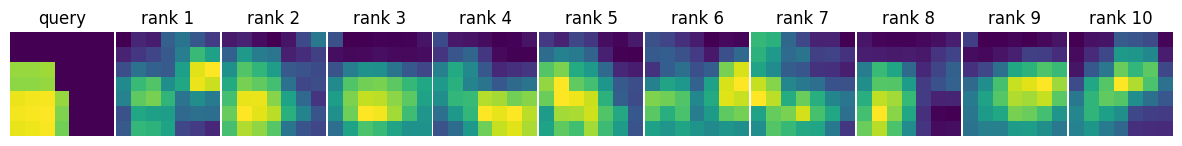

In [308]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

ranked_list = all_img_ids[indices[query_idx]]
feature_maps = all_img_features[indices[query_idx]].view(len(indices[query_idx]), 2048, 7, 7).cpu().numpy()
# feature_maps = masked_img_features[indices[query_idx]].view(len(indices[query_idx]), 2048, 7, 7).cpu().numpy()

processed_feature_maps = []
for i, fm in enumerate(feature_maps):
    gray = np.average(fm, axis=0)
    gray = gray / gray.shape[0]
    processed_feature_maps.append(gray)
processed_feature_maps = np.stack(processed_feature_maps, axis=0)

# relevant_positions = [idx for idx, img in enumerate(ranked_list) if is_relevant(queries[query_idx], img, coco=coco)]
# print(is_relevant(queries[query_idx], ranked_list[0], coco=coco))
img_paths = [f'./data/coco/val2017/images/000000{all_img_ids[indices[query_idx][i]]:06}.jpg' for i in range(10)]
# img_path = f'./data/coco/val2017/images/000000221281.jpg'
print(query_ids[query_idx])

plt.figure(figsize=(15, 10))

# Display the 'query' image in the first position
plt.subplot(1, 11, 1) # for 1 row and 11 columns (1 query + 10 results)
plt.imshow(gray_scale)
plt.axis('off')
plt.title('query')

# Loop through and display 10 result images
for i in range(10):
    plt.subplot(1, 11, i+2) # for 1 row and 11 columns
    plt.imshow(processed_feature_maps[i])
    plt.axis('off')
    plt.title(f'rank {i+1}')


# for i in range(10):
#     plt.subplot(3, 4, i+2)
#     plt.imshow(processed_feature_maps[i])
#     plt.axis('off')
#     plt.title(f'rank {i+1}, img: {all_img_ids[indices[query_idx][i]]}, distance: {distances[query_idx][i]:.3f}')
plt.subplots_adjust(wspace=0.02, hspace=0)
plt.show()


In [201]:
import clip
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model, transform = clip.load("RN50", device=device)
text_encoder = model.encode_text

100%|███████████████████████████████████████| 244M/244M [00:07<00:00, 32.8MiB/s]


In [205]:
texts = ["a photo of a electronic", "a photo of a pizza"]

# Tokenize and encode the text
text_inputs = clip.tokenize(texts).to(device)
text_features = text_encoder(text_inputs)
# Normalize the features
text_features /= text_features.norm(dim=-1, keepdim=True)

torch.Size([2, 1024])

In [203]:
similarity = torch.dot(text_features[0], text_features[1])
print(similarity)


tensor(0.8408, device='cuda:0', dtype=torch.float16, grad_fn=<DotBackward0>)


In [204]:
import torch
from PIL import Image
import clip
from tqdm import tqdm

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, transform = clip.load("RN50", device=device)

# COCO's 80 classes
coco_classes = [
    "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat", "traffic light", "fire hydrant",
    "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
    "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite", "baseball bat",
    "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl",
    "banana", "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair", "couch", "potted plant",
    "bed", "dining table", "toilet", "tv", "laptop", "mouse", "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink",
    "refrigerator", "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"
]

# Create embeddings for each class
embeddings = {}
with torch.no_grad():
    for class_name in tqdm(coco_classes):
        text = class_name
        text_tkn = clip.tokenize(text).to(device)
        text_features = model.encode_text(text_tkn)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        embeddings[text] = text_features.cpu().numpy()

# Optionally, save the embeddings to disk
import numpy as np
np.save('coco_embeddings_rn50.npy', embeddings)


100%|██████████| 80/80 [00:00<00:00, 149.60it/s]


In [11]:
import fasttext, fasttext.util
import numpy as np
embed_fn = fasttext.load_model('cc.en.300.bin').get_word_vector
coco_classes = [
    "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat", "traffic light", "fire hydrant",
    "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
    "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite", "baseball bat",
    "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl",
    "banana", "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair", "couch", "potted plant",
    "bed", "dining table", "toilet", "tv", "laptop", "mouse", "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink",
    "refrigerator", "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"
]
coco_classes = np.array(coco_classes)
cat_vec = embed_fn('beer')
moon_vec = embed_fn('pizza')
similarity_list = np.array([])
for coco_class in coco_classes:
    coco_vec = embed_fn(coco_class)
    cosine_similarity = np.dot(cat_vec, coco_vec) / (np.linalg.norm(cat_vec) * np.linalg.norm(coco_vec))
    similarity_list = np.append(similarity_list, cosine_similarity)
print(coco_classes[np.argsort(similarity_list)[::-1]])
print(np.sort(similarity_list)[::-1])
# cosine_similarity = np.dot(cat_vec, moon_vec) / (np.linalg.norm(cat_vec) * np.linalg.norm(moon_vec))
# print(cosine_similarity)

['bottle' 'pizza' 'sandwich' 'cup' 'frisbee' 'donut' 'truck' 'skateboard'
 'bicycle' 'surfboard' 'cake' 'toilet' 'snowboard' 'dog' 'airplane'
 'banana' 'refrigerator' 'boat' 'orange' 'motorcycle' 'bowl' 'broccoli'
 'car' 'cow' 'suitcase' 'vase' 'apple' 'backpack' 'skis' 'knife' 'giraffe'
 'sports ball' 'horse' 'handbag' 'potted plant' 'couch' 'wine glass'
 'sink' 'kite' 'oven' 'bed' 'laptop' 'carrot' 'elephant' 'toothbrush'
 'bus' 'keyboard' 'baseball glove' 'umbrella' 'toaster' 'sheep' 'bench'
 'spoon' 'chair' 'bird' 'cell phone' 'cat' 'book' 'person' 'scissors'
 'tennis racket' 'zebra' 'microwave' 'parking meter' 'fork' 'hot dog'
 'stop sign' 'bear' 'tv' 'dining table' 'teddy bear' 'tie' 'baseball bat'
 'train' 'traffic light' 'hair drier' 'mouse' 'clock' 'fire hydrant'
 'remote']
[0.53841919 0.48821327 0.36961731 0.33272642 0.31498536 0.30846298
 0.30396703 0.2975249  0.28811723 0.27173054 0.27100903 0.26492041
 0.26472148 0.2588546  0.25390029 0.25018683 0.24965011 0.24606858
 0.23